In [1]:
# import basic necessities
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import OneHotEncoder
import yaml
import os
import sys

# retrieve data
from ucimlrepo import fetch_ucirepo, list_available_datasets

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import train test
from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid")

In [2]:
import sys
sys.path.insert(0, '../')

from util import calculate_disparate_impact, calculate_statistical_parity_difference
from bias_aware_gridsearch import BiasAwareGridSearchCV

## Data Processing

In [3]:
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets
adults_df_raw = pd.concat([X,y], axis=1)
adults_df = adults_df_raw.copy()

In [4]:
# encode output variable to binary
adults_df['income'] = adults_df['income'].apply(lambda x: 1 if '<' in x else 0)

In [5]:
# filter for only US entries
adults_df = adults_df[adults_df['native-country']=='United-States']

## Missingness

In [6]:
adults_df.isna().sum()

age                 0
workclass         871
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        874
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country      0
income              0
dtype: int64

In [7]:
adults_df = adults_df.dropna()

## EDA

In [8]:
adults_df.replace('?', np.nan, inplace=True)

### Basic Descriptive Statistics

In [9]:
adult.metadata.abstract

'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. '

In [10]:
adult.metadata.repository_url

'https://archive.ics.uci.edu/dataset/2/adult'

In [11]:
adults_df.shape

(42958, 15)

In [12]:
adults_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int64
dtype: object

In [13]:
adults_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,42958.000000,4.295800e+04,42958.000000,42958.000000,42958.000000,42958.000000,42958.000000
mean,38.696401,1.872452e+05,10.186810,1105.282811,88.876787,40.620420,0.752689
std,13.633856,1.051209e+05,2.391466,7513.452483,405.926451,12.336794,0.431454
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.158060e+05,9.000000,0.000000,0.000000,40.000000,1.000000
50%,37.000000,1.766930e+05,10.000000,0.000000,0.000000,40.000000,1.000000
75%,48.000000,2.346400e+05,12.000000,0.000000,0.000000,45.000000,1.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


### Plots

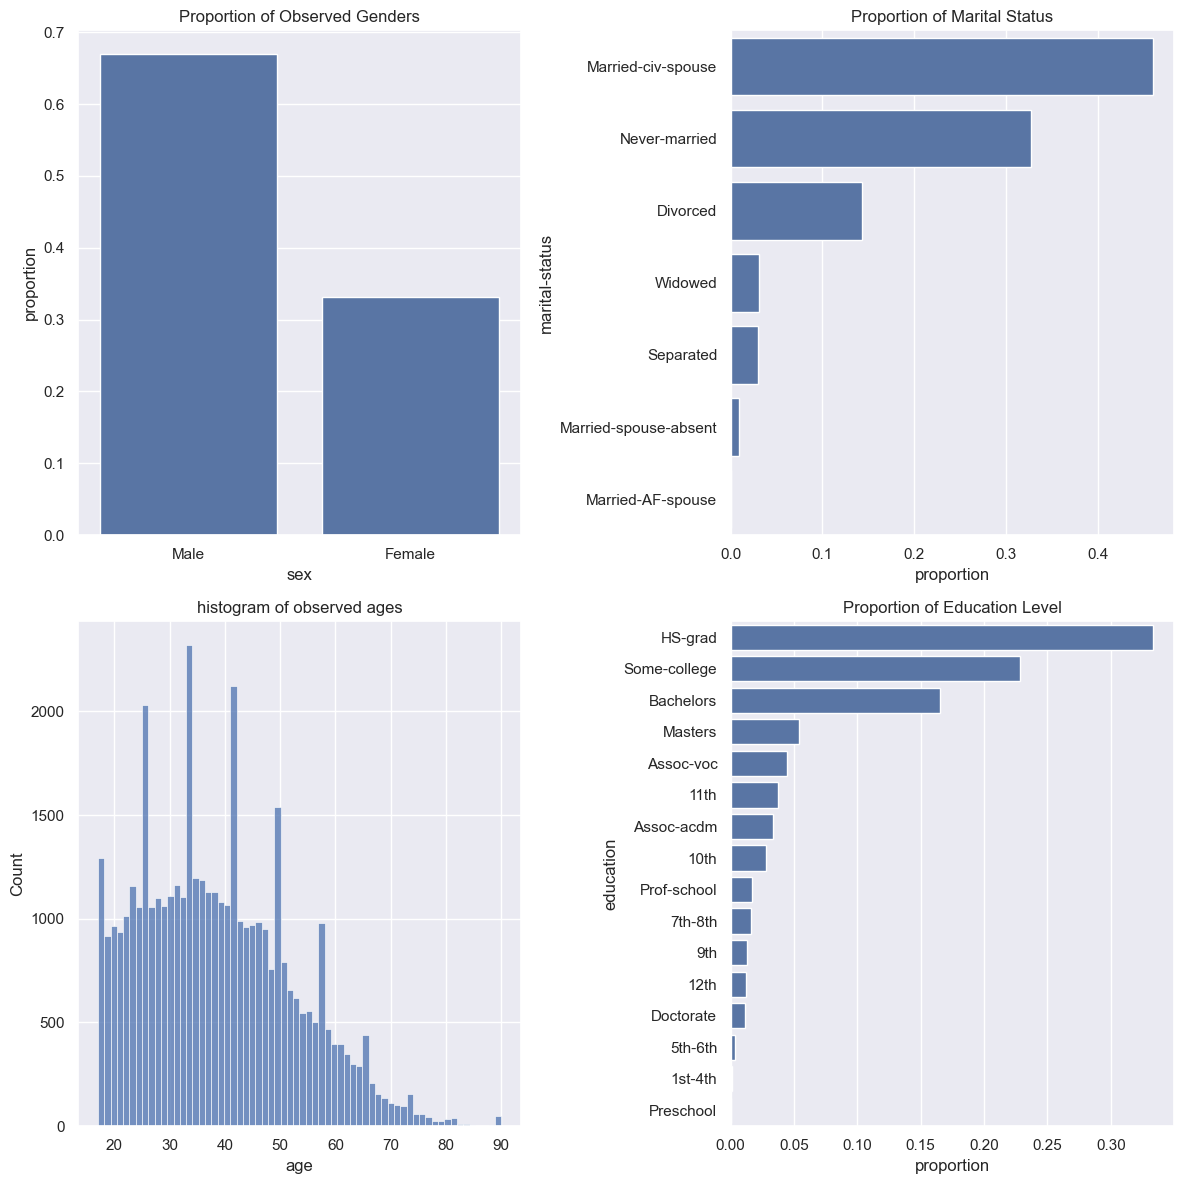

In [14]:
# Create 2x2 axis for plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# prop of sex plot
prop_sex = adults_df['sex'].value_counts(normalize=True)
prop_sex_df = pd.DataFrame({'sex': prop_sex.index, 'proportion': prop_sex.values})
sns.barplot(data=prop_sex_df, x='sex', y='proportion', ax=axes[0,0])
axes[0, 0].set_title("Proportion of Observed Genders")

# prop of marital status plot
prop_marital = adults_df['marital-status'].value_counts(normalize=True)
prop_marital_df = pd.DataFrame({'marital-status': prop_marital.index, 'proportion': prop_marital.values})
sns.barplot(data=prop_marital_df, y='marital-status', x='proportion', ax=axes[0,1])
axes[0, 1].set_title("Proportion of Marital Status")

# prop of education level plot
prop_education = adults_df['education'].value_counts(normalize=True)
prop_education_df = pd.DataFrame({'education': prop_education.index, 'proportion': prop_education.values})
sns.barplot(data=prop_education_df, y='education', x='proportion', ax=axes[1,1])
axes[1,1].set_title("Proportion of Education Level")

# age plot
sns.histplot(adults_df['age'], ax=axes[1,0])
axes[1,0].set_title('histogram of observed ages')

# Show the plot
plt.tight_layout()
plt.show()

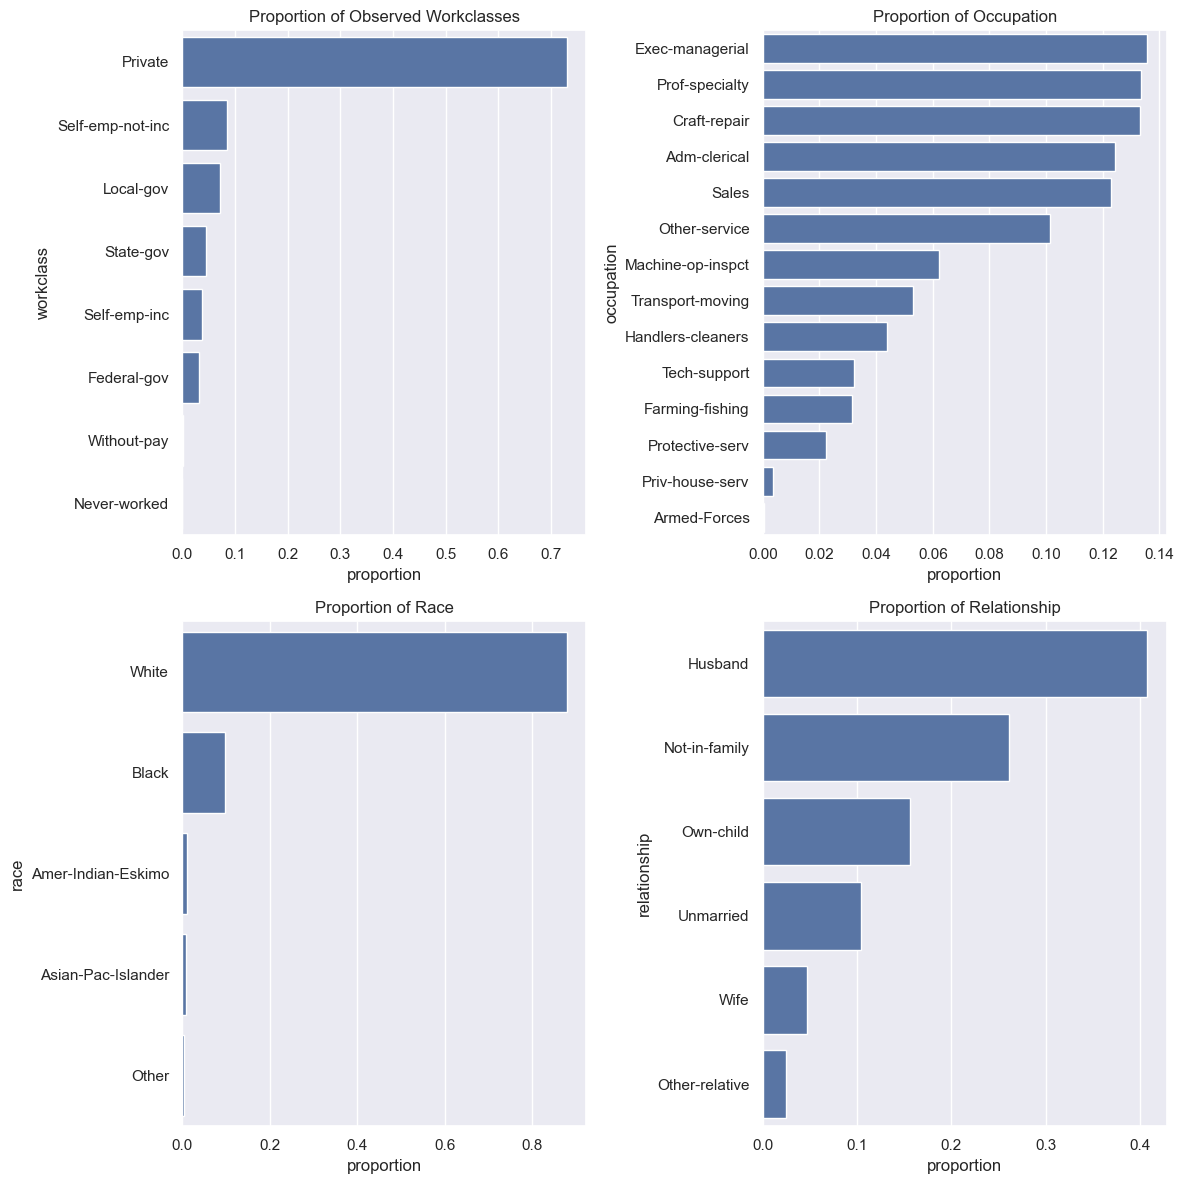

In [15]:
# Create 2x2 axis for plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# prop of work class plot
prop_class = adults_df['workclass'].value_counts(normalize=True)
prop_class_df = pd.DataFrame({'workclass': prop_class.index, 'proportion': prop_class.values})
sns.barplot(data=prop_class_df, y='workclass', x='proportion', ax=axes[0,0])
axes[0, 0].set_title("Proportion of Observed Workclasses")

# prop of occupation plot
prop_occupation = adults_df['occupation'].value_counts(normalize=True)
prop_occupation_df = pd.DataFrame({'occupation': prop_occupation.index, 'proportion': prop_occupation.values})
sns.barplot(data=prop_occupation_df, y='occupation', x='proportion', ax=axes[0,1])
axes[0, 1].set_title("Proportion of Occupation")

# prop of relationship plot
prop_relationship = adults_df['relationship'].value_counts(normalize=True)
prop_relationship_df = pd.DataFrame({'relationship': prop_relationship.index, 'proportion': prop_relationship.values})
sns.barplot(data=prop_relationship_df, y='relationship', x='proportion', ax=axes[1,1])
axes[1,1].set_title("Proportion of Relationship")

# prop of race plot
prop_race = adults_df['race'].value_counts(normalize=True)
prop_race_df = pd.DataFrame({'race': prop_race.index, 'proportion': prop_race.values})
sns.barplot(data=prop_race_df, y='race', x='proportion', ax=axes[1,0])
axes[1,0].set_title("Proportion of Race")

# Show the plot
plt.tight_layout()
plt.show()

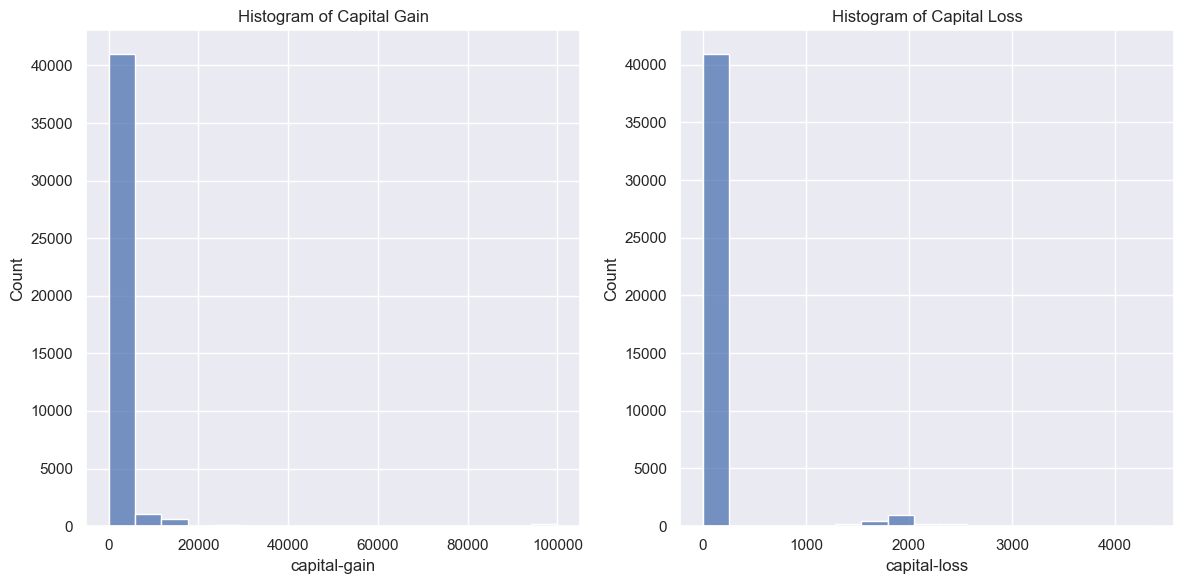

In [16]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram on the first subplot
sns.histplot(adults_df['capital-gain'], ax=axes[0])
axes[0].set_title("Histogram of Capital Gain")
# Add any other customizations like axes[0].set_xlabel(), axes[0].set_ylabel(), etc.

# Plot the second histogram on the second subplot
sns.histplot(adults_df['capital-loss'], ax=axes[1])
axes[1].set_title("Histogram of Capital Loss")
# Similarly, customize the second subplot as needed

# Show the plot
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

## Naive Model Selection

In [17]:
# Specify the columns to encode
columns_to_encode = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')

# Fit and transform the specified columns and convert to DataFrame
encoded_columns = pd.DataFrame(encoder.fit_transform(adults_df[columns_to_encode]))

# Get the new column names from the encoder
encoded_columns.columns = encoder.get_feature_names_out(columns_to_encode)

# Reset the index of original DataFrame to allow for concatenation
adults_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame (minus the columns to encode) with the new encoded columns
df_encoded = pd.concat([adults_df.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

In [18]:
# drop unecessary columns
df_encoded = df_encoded.drop(columns=['education', 'native-country'])

In [19]:
# split into input/output variables
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

In [20]:
# train test split, seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
calculate_disparate_impact(df_encoded, 'income', 'race_White', True, False)

-0.17551107484810458

## Naive Model Building

In [22]:
# load in params
parent_dir = os.path.dirname(os.getcwd())
params_path = os.path.join(parent_dir, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)

In [23]:
param_grid_file['detailed_rfc_params']

{'n_estimators': [50, 100, 200, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [20, 30, 40, 50, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

In [24]:
# Settings to test
param_grid = param_grid_file['detailed_rfc_params']

rfc = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rfc,param_grid, n_jobs=4)
clf.fit(X_train, y_train)

best_parameters = clf.best_params_
best_score = clf.best_score_
best_model = clf.best_estimator_

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

### Model Evaluation

In [25]:
loaded_model = joblib.load('best_model.pkl')

In [26]:
temp = pd.concat([X_train,y_train], axis=1)

In [27]:
temp

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,income
32775,48,65584,10,0,0,40,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
42347,31,55912,5,0,0,47,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
28581,55,100054,6,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
12618,51,84399,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
5929,19,131615,9,0,0,40,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,37,190964,9,0,0,40,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
11284,17,285169,7,0,0,40,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
38158,27,203558,10,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
860,44,398473,10,0,0,70,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0


In [28]:
calculate_disparate_impact(temp, 'income', 'sex_Male', True, False)

-0.2940138234177516

In [29]:
y_pred = loaded_model.predict(X_train)

In [30]:
temp = X_test.copy().reset_index().drop(columns=['index'])

In [31]:
temp['y_pred'] = pd.Series(y_pred)

In [47]:
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.015244284730120627

## Bias Aware Model Selection

In [33]:
param_grid = param_grid_file['detailed_rfc_params']

In [35]:
estimator = RandomForestClassifier(random_state=42)
grid_search = BiasAwareGridSearchCV(
    estimator, param_grid, df_encoded, 'income', 'sex_Male', True, False, verbose=False)

In [37]:
grid_search.fit(X_train, y_train, calculate_disparate_impact)

In [38]:
joblib.dump(grid_search, 'grid_serach_results.pkl')

['grid_serach_results.pkl']

In [39]:
highest_acc_rfc_bgs = RandomForestClassifier()
highest_acc_rfc_bgs.set_params(**max(grid_search.results_, key=lambda x: x['accuracy'])['params'])
highest_acc_rfc_bgs.fit(X_train, y_train)
joblib.dump(highest_acc_rfc_bgs, 'highest_acc_bgs.pkl')

['highest_acc_bgs.pkl']

In [40]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(highest_acc_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.014906575638471087

In [41]:
lowest_bias_rfc_bgs = RandomForestClassifier()
lowest_bias_rfc_bgs.set_params(**min(grid_search.results_, key=lambda x: np.abs(x['bias']))['params'])
lowest_bias_rfc_bgs.fit(X_train, y_train)
joblib.dump(lowest_bias_rfc_bgs, 'lowest_bias_bgs.pkl')

['lowest_bias_bgs.pkl']

In [42]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(lowest_bias_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.013676415690247912

In [43]:
balanced_rfc_bgs = RandomForestClassifier()
top_accurate_models = sorted(grid_search.results_, key=lambda x: x['accuracy'], reverse=True)[:25]
balanced_rfc_bgs.set_params(**min(top_accurate_models, key=lambda x: np.abs(x['bias']))['params'])
balanced_rfc_bgs.fit(X_train, y_train)
joblib.dump(balanced_rfc_bgs, 'balanced_bgs.pkl')

['balanced_bgs.pkl']

In [44]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(balanced_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.010904429744946098

In [45]:
optimum_rfc_bgs = RandomForestClassifier()

max_accuracy = max(result['accuracy'] for result in grid_search.results_)

# Filter models within the specified margin of the highest accuracy
eligible_models = [result for result in grid_search.results_ if result['accuracy'] >= max_accuracy - 0.1]

# Select the model with the least bias among these
best_model = min(eligible_models, key=lambda x: np.abs(x['bias']))

optimum_rfc_bgs.set_params(**best_model['params'])
optimum_rfc_bgs.fit(X_train,y_train)

joblib.dump(optimum_rfc_bgs, 'optimum_bgs.pkl')

['optimum_bgs.pkl']

In [46]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(optimum_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.015244284730120627

## Comparison

## Conclusion